In [2]:

# sessionInfo()
suppressPackageStartupMessages({
    library(DESeq2)
    library(dplyr)
    library(ggplot2)
    library(ggrepel)
    library(ggpubr)
#     library(pheatmap)
    library(RColorBrewer)
    library(cowplot)
    library(Matrix)
    library(stringr)
    library(edgeR)
    library(data.table)
    library(tidyr)
    library(readr)
#     library(clusterProfiler)
#     library(enrichplot)
#     library(DOSE)
    library(ggrastr)
    library(tictoc)
    library(EnhancedVolcano)
})







### Input File Names

In [3]:
outdir_bulk = '/nfs/lab/projects/islet_multiomics_stress_CoCl2/pipeline/DESeq/rna/bulkIslet_RNA/'
input_dds_filename = paste0(outdir_bulk, 'post_deseq.dds_bulk38_Donor_plus_Treatment.filterGenesLessThan2ReadsPerTreatment_Base.Summed_REPLICATES.rds')
input_res_filename = paste0(outdir_bulk, 'deseq.RESULTS_DF.dds_bulk38.filtered.geneID_geneName_annotated.counts_and_TPMs.SUMMED_REPLICATES.rds')
input_res_filename_txt = paste0(outdir_bulk, 'deseq.RESULTS.dds_bulk38.filtered.geneID_geneName_annotated.counts_and_TPMs.SUMMED_REPLICATES.txt')

ALPHA = 0.1

In [4]:

tic('Read DESeqDataSet object (post DESeq)')
dds_post_DESeq <- readRDS(input_dds_filename)
toc()


tic('Read DESeq Results Table from rds')
res_df = readRDS(input_res_filename)
toc()

## OR ###
tic('Read DESeq Results Table from tsv / txt')
res_df_fromTXT  = read.table(input_res_filename_txt)
toc()

Read DESeqDataSet object (post DESeq): 0.931 sec elapsed
Read DESeq Results Table from rds: 0.165 sec elapsed
Read DESeq Results Table from tsv / txt: 0.204 sec elapsed


In [5]:
as.data.frame(colData(dds_post_DESeq))

,sample_label,time,batch,condition,donor_batch,Treatment,Donor,Donor_treatment,sizeFactor
,<chr>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>
CO1_rep1c,CO1_rep1c,24,B,CoCl2_24,R382_B,CoCl2,R382,R382__CoCl2,0.9919475
UT1_rep1c,UT1_rep1c,24,B,Unt_24,R382_B,Unt,R382,R382__Unt,1.1487182
CO2_rep1c,CO2_rep1c,24,B,CoCl2_24,R385_B,CoCl2,R385,R385__CoCl2,1.0405651
UT2_rep1c,UT2_rep1c,24,B,Unt_24,R385_B,Unt,R385,R385__Unt,0.4369300
R395_CoCl2_1,R395_CoCl2_1,24,C,CoCl2_24,R395_C,CoCl2,R395,R395__CoCl2,1.7539946
R395_UNT,R395_UNT,24,C,Unt_24,R395_C,Unt,R395,R395__Unt,1.2038941


In [6]:
head(as.data.frame(counts(dds_post_DESeq)))

,CO1_rep1c,UT1_rep1c,CO2_rep1c,UT2_rep1c,R395_CoCl2_1,R395_UNT
,<int>,<int>,<int>,<int>,<int>,<int>
TSPAN6,368,487,624,249,725,243
DPM1,854,966,971,355,2296,1340
SCYL3,469,584,568,234,857,596
C1orf112,234,301,235,126,407,246
FGR,6,8,9,6,43,20
CFH,157,236,333,210,581,469


In [8]:
postProcess_results_df <- function(res, pval_cutoff1, padj_cutoff1, hypoxiaGeneList, topLabelCount){
   res$log10_pval = -log10(res$pvalue)
   res$Gene = rownames(res)
    res <- res[order(res$pvalue),]
    res$log10_exp_p = -log10(ppoints(length(res$pvalue)))
    res$log10_padj = -log10(res$padj) # only used for rank order
#     res$FDR_from_p.adjust <-  p.adjust(res$pvalue, method = "BH")
    
    res <- res %>% 
        mutate(isSig_padj = case_when(
            padj <= padj_cutoff1 ~ TRUE,
            TRUE ~ FALSE
          ))
    
    res <- res %>% 
        mutate(isSig_pval = case_when(
            pvalue <= pval_cutoff1 ~ TRUE,
            TRUE ~ FALSE
          ))
  
    res <- res %>%
      mutate(Dir = case_when(
        log2FoldChange > 0   ~ 'UP',
        log2FoldChange < 0 ~ 'DOWN',
        TRUE ~ 'No_Change'
      ))
    res <- res %>%
          mutate(Direction  = case_when(
           Dir == 'UP' ~ "Up",
           Dir == 'DOWN'  ~ "Down"
          ))


    res <- res %>%
      mutate(Significance = case_when(
        Dir == 'UP' & isSig_padj ~ 'Up-regulated',
        Dir == 'DOWN' & isSig_padj ~ 'Down-regulated',
        TRUE ~ 'No_Change'
      ))
    
    res <- res %>% 
        mutate(isUp = case_when(
            Dir == 'UP' ~ TRUE,
            TRUE ~ FALSE
          ))
    
    res <- res %>% 
        mutate(isDown = case_when(
            Dir == 'DOWN' ~ TRUE,
            TRUE ~ FALSE
          ))
    
    res <- res %>%
          mutate(Label_sig = case_when(
            isSig_padj ~ Gene,
            TRUE ~ ''
          ))

    res$rankOrderValue = .1 * res$log10_padj * abs(res$log2FoldChange)
    res = res[order(-res$rankOrderValue ),]
    res_Top = res[1:topLabelCount,]
    res_Bottom = res[(topLabelCount+1):nrow(res),]
    res_Top$LabelTop = res_Top$Gene
    res_Bottom$LabelTop = ''
    res <- rbind(res_Top, res_Bottom)

    res <- res %>%
          mutate(LabelTop = case_when(
            padj == 0  ~ Gene,
            TRUE ~ LabelTop
          ))

    res <- res %>%
          mutate(Significance_Plot = case_when(
            isSig_padj & Dir == 'UP' ~ 'Up-regulated',
            isSig_padj & Dir == 'DOWN' ~ 'Down-regulated',
            TRUE ~ 'No_Change'
          ))
    
 res <- res %>%
      mutate(log10_pval = case_when(
        log10_pval == Inf ~ 350,
        TRUE ~ log10_pval
      ))


    # res_v2 <- res
    res_neg <- res %>% filter(Dir == 'DOWN')
    res_neg <- res_neg %>% 
          arrange(desc(log10_pval))
    res_neg_rn <- rownames(res_neg)
    res_neg_rn_top <- res_neg_rn[1:3]

 res <- res %>%
          mutate(LabelTop = case_when(
            Gene %in% res_neg_rn_top  ~ Gene,
            TRUE ~ LabelTop
          ))

    
    return(res)
}















In [9]:
res_df_processed <- postProcess_results_df(res_df, .05, .01, c(), 20)

In [10]:
head(res_df_processed)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,gene_name,gene_width,log10_pval,⋯,isBigLFC,isSig_FDR,isSig_padj,rankOrderValue,LabelTop,LogFoldChangeAnnotation,Direction,Significance_Plot,Significance_pval,log10_padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
HMOX1,5709.0481,2.750885,0.1273759,21.596592,1.933664e-103,3.308693e-99,ENSG00000100292.18,HMOX1,13854,102.71362,⋯,TRUE,TRUE,TRUE,27.090811,HMOX1,Up-regulated,Up,Up-regulated,Up-regulated,98.48034
DEPP1,10600.8788,1.915827,0.1863921,10.278478,8.810812e-25,5.025394e-21,ENSG00000165507.9,DEPP1,7829,24.05498,⋯,TRUE,TRUE,TRUE,3.888905,DEPP1,Up-regulated,Up,Up-regulated,Up-regulated,20.29883
HIF1A.AS3,312.6112,2.490411,0.2783880,8.945826,3.691772e-19,7.896238e-16,ENSG00000258667.3,HIF1A-AS3,43866,18.43277,⋯,TRUE,TRUE,TRUE,3.761163,HIF1A.AS3,Up-regulated,Up,Up-regulated,Up-regulated,15.10258
FAM107A,118.2993,-2.658874,0.3084175,-8.621022,6.635939e-18,1.032251e-14,ENSG00000168309.18,FAM107A,63494,17.17810,⋯,TRUE,TRUE,TRUE,3.718759,FAM107A,Down-regulated,Down,Down-regulated,Down-regulated,13.98621
HILPDA,519.5719,2.425770,0.2757353,8.797458,1.399499e-18,2.660759e-15,ENSG00000135245.10,HILPDA,2570,17.85403,⋯,TRUE,TRUE,TRUE,3.535558,HILPDA,Up-regulated,Up,Up-regulated,Up-regulated,14.57499
SLC43A2,2551.6063,-1.300593,0.1215231,-10.702433,9.914070e-27,8.481982e-23,ENSG00000167703.15,SLC43A2,59619,26.00375,⋯,TRUE,TRUE,TRUE,2.870605,SLC43A2,Down-regulated,Down,Down-regulated,Down-regulated,22.07150


In [11]:
res_df = res_df_processed
res_df_processed = NULL

In [ ]:
outdir_bulk = '/nfs/lab/projects/islet_multiomics_stress_CoCl2/pipeline/figures/'

outfilename3 = paste0(outdir_bulk,  'bulkRNA.primaryIslets.DESeqResults.annotated.txt')
write.table(res_df, file = outfilename3, quote=FALSE, sep='\t', col.names = TRUE, row.names=TRUE)


## Plot Results

#### Plot with EnhancedVolcano

In [14]:
p_eh <- EnhancedVolcano(  res_df,
                                        lab = rownames(res_df),
                                        x = 'log2FoldChange',
                                        y = 'pvalue',
                                        title = paste0('DEGs in CoCl2 Treated Primary Islets'),
                                                    pCutoff = (0.05),
                                        drawConnectors = TRUE,
                                        widthConnectors = 0.5,
                                        labSize = 3.5               )

Warning message:
"ggrepel: 272 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


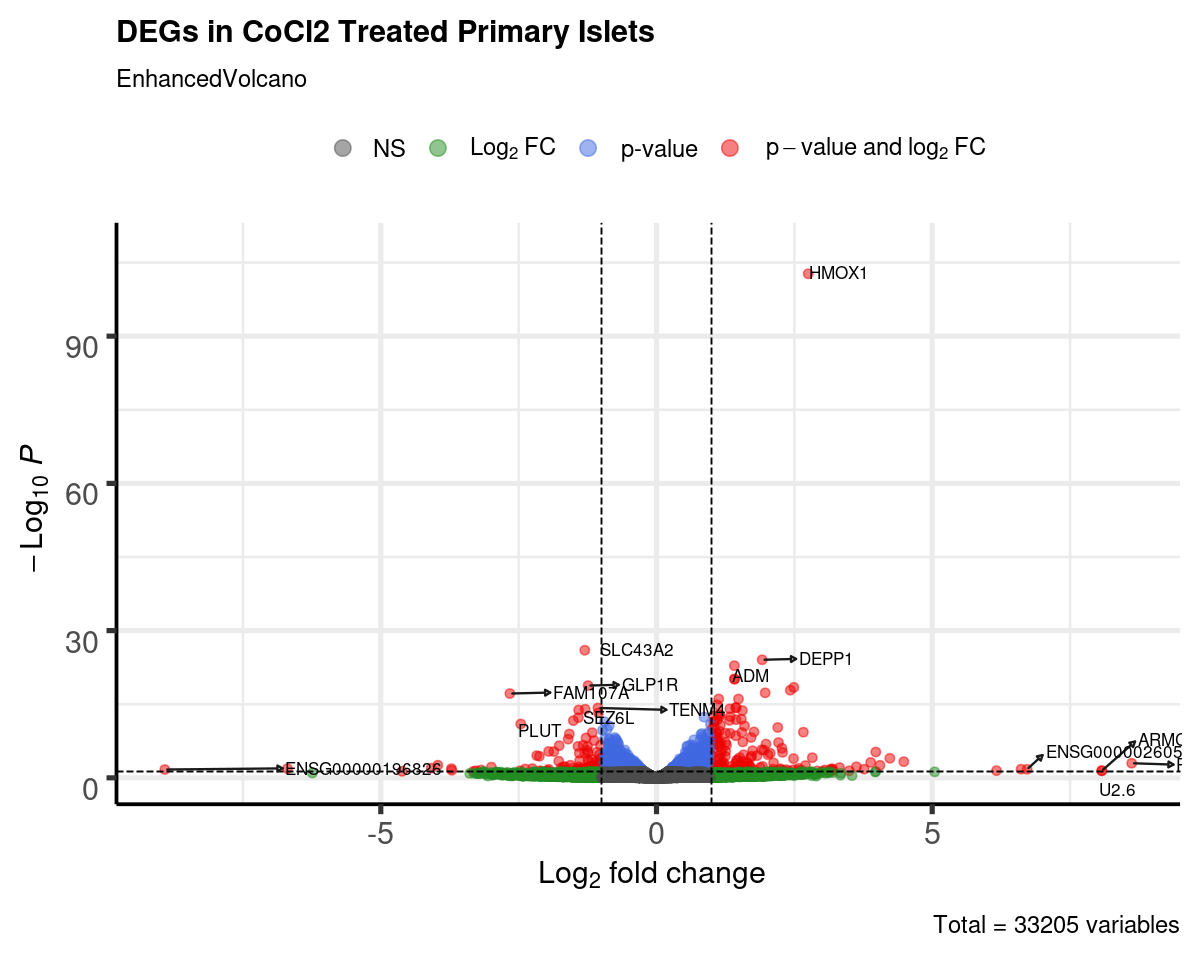

In [15]:
options(repr.plot.width=10, repr.plot.height=8)
p_eh

#### Plot with ggplot2

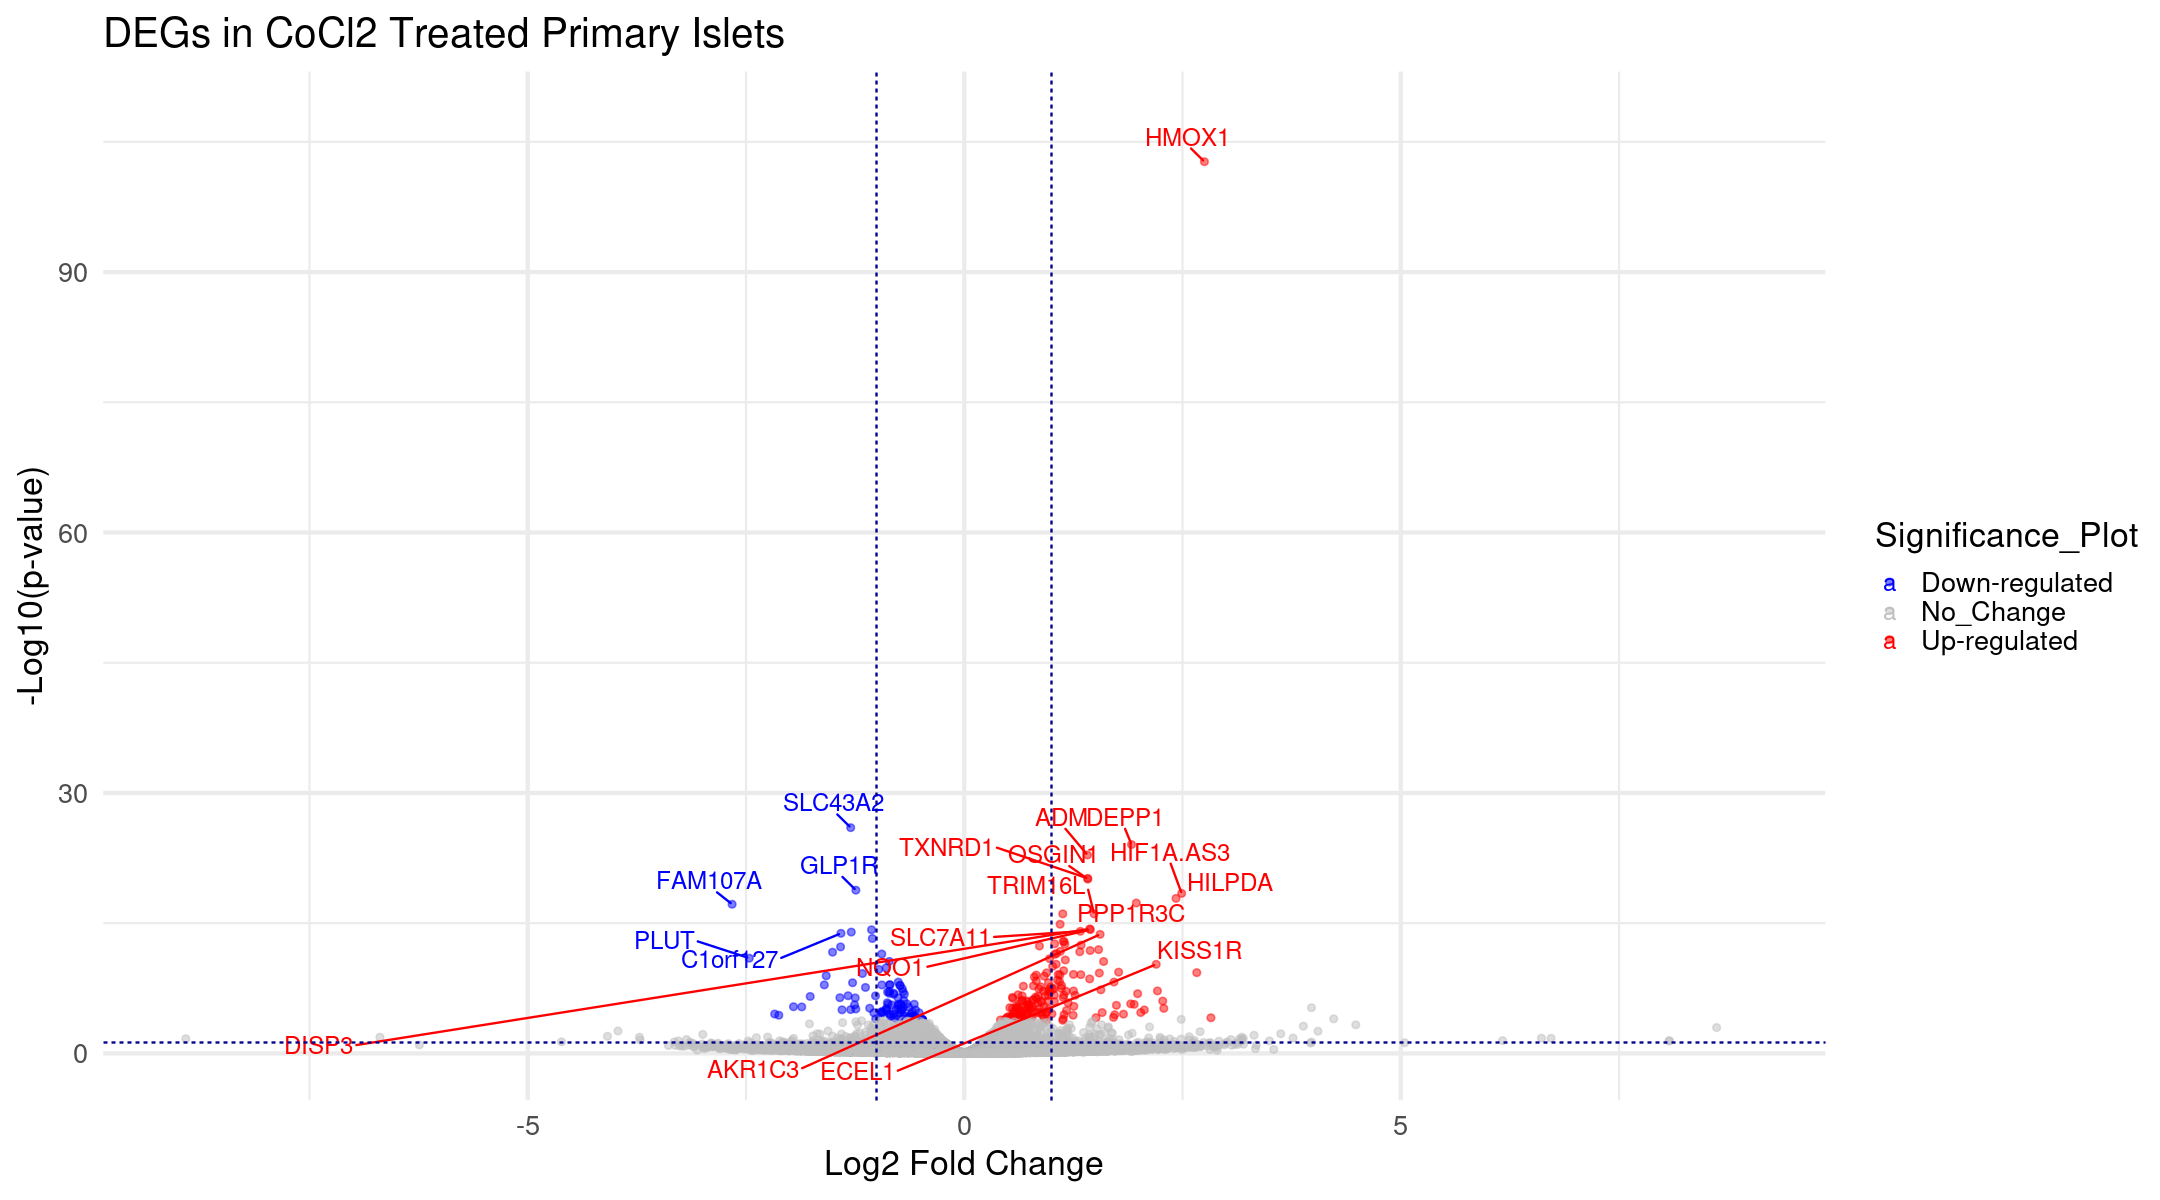

In [22]:
options(repr.plot.width=18, repr.plot.height=10)
plot_colors = c("Not Significant" = "gray", "Upregulated" = "red", "Downregulated" = "blue")
plot_colors = c( "blue", "gray", "red")
# plot_colors = c("Not Significant" = "gray", "Upregulated" = "red")
# Create the volcano plot
ylim_max = max(res_df$log10_pval) + 5
xlim_max = max(abs(res_df$log2FoldChange)) + .05
p <- ggplot(res_df, aes(x = log2FoldChange, y = log10_pval, color = Significance_Plot, label = LabelTop )) +
 geom_point(alpha = 0.5) +
  ylim(0,ylim_max) + xlim(-xlim_max, xlim_max) + 
  theme_minimal() +
  labs(
    title = "DEGs in CoCl2 Treated Primary Islets",
    x = "Log2 Fold Change",
    y = "-Log10(p-value)"
  ) +
  theme(plot.title = element_text(hjust = 0.5), margin = margin(t = 20, r = 0, b = 10, l = 0) ) +  
scale_color_manual(values = plot_colors)   + 
    geom_text_repel( data=res_df, max.overlaps = 50, size = 5, hjust = -.2, vjust = -.2) +  theme_minimal(base_size = 20) + 
  geom_hline(yintercept = -log10(0.05), col = "darkblue", linetype = "dashed") +  # significance threshold
  geom_vline(xintercept = c(-1, 1), col = "darkblue", linetype = "dashed")  # fold change thresholds + 

p 

In [ ]:
  scOutDir = '/nfs/lab/projects/islet_multiomics_stress_CoCl2/pipeline/figures/'

ggsave(
  filename = paste(outdir_bulk, 'primaryIslets.DESeqResults.pdf'),
  plot = p ,
    width = 18,
    height = 10,
    unit = 'in',
  device = 'pdf',
  dpi = 900
)

#### Plot with ggplot2, using ggrastr

In [ ]:
options(repr.plot.width=18, repr.plot.height=10)
plot_colors = c("Not Significant" = "gray", "Upregulated" = "red", "Downregulated" = "blue")
plot_colors = c( "blue", "gray", "red")
# plot_colors = c("Not Significant" = "gray", "Upregulated" = "red")
# Create the volcano plot
p2 <- ggplot(res_72h, aes(x = log2FoldChange, y = log10_pval, color = Significance_Plot, label = LabelTop )) +
 rasterize(geom_point(alpha = 0.5),dpi=900) +
# geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(
    title = "Differentially Expressed Genes in 72 Hour Treated EndoC",
    x = "Log2 Fold Change",
    y = "-Log10(p-value)"
  ) +
  theme(plot.title = element_text(hjust = 0.5), margin = margin(t = 20, r = 0, b = 10, l = 0) ) +  
scale_color_manual(values = plot_colors)   + xlim(-10,10) + ylim(0,(max(res_24h$log10_pval) + 20))   + 
    geom_text_repel( data=res_72h, max.overlaps = 50, size = 5, hjust = -.2, vjust = -.2) +  
# expand_limits(x = c(-10, 10), y = c(0, Inf)) +
theme_minimal(base_size = 20) + 
  geom_hline(yintercept = -log10(0.05), col = "darkblue", linetype = "dashed") +  # significance threshold
  geom_vline(xintercept = c(-1, 1), col = "darkblue", linetype = "dashed")  # fold change thresholds + 

p2 

In [ ]:
  scOutDir = '/nfs/lab/projects/islet_multiomics_stress_CoCl2/pipeline/figures/'

ggsave(
  filename = paste(outdir_bulk, 'primaryIslets.DESeqResults.rast.pdf'),
  plot = p2 ,
    width = 18,
    height = 10,
    unit = 'in',
  device = 'pdf',
  dpi = 900
)